### i) Import packages

In [1]:
import pandas as pd 
import numpy as np
import string, re
import nltk
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer, CountVectorizer
from sklearn import naive_bayes,metrics, linear_model,svm, grid_search
import time,random
import operator
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import style
plt.style.use('ggplot')

In [2]:
# Import nltk stopwords and lemmatizer
stop_list = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()
punctuation = list(string.punctuation)
stop_list = stop_list + punctuation +["rt", 'url']

### ii) Preprocess data

In [3]:
# Read kaggle data set from .csv-file
data_wneutral = pd.read_csv("Sentiment.csv")
data = data_wneutral[data_wneutral['sentiment'] !='Neutral']
classifier =[]
# Preprocess of tweet-text-column: delete hashes, take out links, delete punctuation

def preprocess(tweet):
    if type(tweet)!=type(2.0):
        tweet = tweet.lower()
        tweet = tweet.replace("#bernieorbust", "positive")
        tweet = tweet.replace("#imwithher", "positive")
        tweet = tweet.replace("#votetrump2016", "positive")
        tweet = tweet.replace("#onlytrump", "positive")
        tweet = tweet.replace("#notmeus", "positive")
        tweet = tweet.replace("#stillsanders", "positive")
        tweet = tweet.replace("#hillarybros", "positive")
        tweet = tweet.replace("#latinos4bernie", "positive")
        tweet = tweet.replace("#americafirst", "positive")
        tweet = tweet.replace("#singsing4hillary", "positive")
        tweet = tweet.replace("#hillary2016pres", "positive")
        tweet = tweet.replace("#bernietheman", "positive") 
        tweet = tweet.replace("#america1st", "positive")
        tweet = tweet.replace("#teamtrump", "positive")
        tweet = tweet.replace("#antiwar", "positive")
        tweet = tweet.replace("#wearebernie", "positive")
        tweet = tweet.replace("#sheswithus", "positive") 
        tweet = tweet.replace("#empowering", "positive") 
        
        tweet = tweet.replace("#bernielaheadquarters", "positive")
        tweet = tweet.replace("#votebernie", "positive")    
        tweet = tweet.replace("#calibernication", "positive")
        tweet = tweet.replace("#teamamerica", "positive")
        
        tweet = tweet.replace("#vote4hillary", "positive")
        tweet = tweet.replace("#berniestrong", "positive")
            
        tweet = tweet.replace("#vivabernie", "positive")
        
        tweet = tweet.replace("#bernieforpresident", "positive")
        tweet = tweet.replace("#imwithhillary", "positive")    
        tweet = tweet.replace("#berniebus", "positive")      
        tweet = tweet.replace("#latinosforhillary", "positive")                               
        tweet = tweet.replace("#trumptractor", "positive")    
                                      
        tweet = tweet.replace("#bernieforpresident", "positive")
        tweet = " ".join(tweet.split('#'))
        
        tweet = re.sub('((www\.[^\s]+)|(https://[^\s]+))','URL',tweet)
        tweet = re.sub("http\S+", "URL", tweet)
        tweet = re.sub("https\S+", "URL", tweet)
        tweet = re.sub('@[^\s]+','AT_USER',tweet)
        tweet = re.sub(r'[0-9]*','',tweet)
        tweet = re.sub(r'@[a-zA-Z0-9]*', '', tweet)
        tweet = tweet.replace("AT_USER","")
        tweet = tweet.replace("URL","")
        tweet = tweet.replace(".","")
        tweet = tweet.replace('\"',"")
        tweet = tweet.replace('&amp',"")
        # Replace smileys with polarity
        tweet = tweet.replace(":-D", "positive")
        tweet = tweet.replace(":D", "positive")
        tweet = tweet.replace(":-)", "positive")
        tweet = tweet.replace(":)", "positive")
        tweet = tweet.replace("=D", "positive")
        tweet = tweet.replace("xD", "positive")
        tweet = tweet.replace("(^^)", "positive")
        tweet = tweet.replace("<3", "positive")
        tweet = tweet.replace("(L)", "positive")
        tweet = tweet.replace(":-(", "negative")
        tweet = tweet.replace(":(", "negative")
        tweet = tweet.replace(":'(", "negative")
        tweet = tweet.replace(":'-(", "negative")
        tweet = tweet.replace(":$", "negative")
        tweet = tweet.replace(":-$", "negative")
        tweet = tweet.replace(":-/", "negative")
        tweet  = " ".join([word for word in tweet.split(" ") if word not in stop_list])
        tweet  = " ".join([word for word in tweet.split(" ") if re.search('^[a-z]+$', word)])
        tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet.split(" ")])
        tweet = re.sub('[\s]+', ' ', tweet)
        tweet = tweet.strip('\'"')
    else:
        tweet=''
    return tweet

data['processed_text'] = data.text.apply(preprocess)
categories = data.sentiment.unique()
categories  = categories.tolist()

x = data.processed_text.values
y = data.sentiment.values

C:\Users\Philipp\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
pd.Series(y).value_counts()

Negative    8493
Positive    2236
dtype: int64

In [5]:
data.shape
#data

(10729, 22)

### iii) Prepare training and test set, display of output

In [6]:
import sentlex
import sentlex.sentanalysis

In [7]:
SWN = sentlex.SWN3Lexicon()

xxx = sentlex.sentanalysis.BasicDocSentiScore()

new_x = pd.DataFrame({'tweet': x})

pos = []
neg = []

for i in enumerate(new_x['tweet']):
    scores = xxx.classify_document(i[1], tagged = False, L = SWN, a=True, v=True, n=False, negation=False, verbose=False)
    pos.append(scores[0])
    neg.append(scores[1])
new_features = pd.DataFrame({'pos': pos, 'neg': neg})

new_x = pd.concat([new_x, new_features], axis = 1)

In [8]:
# Read crawled tweets
data_evaluation = pd.read_csv("Data2.csv", sep=";")
data_evaluation['processed_text'] = data_evaluation.text.apply(preprocess)

In [10]:
# Remove NaN from processed text values
data_evaluation_nn = data_evaluation[data_evaluation.processed_text.notnull()]

### vii) Perform classification

In [11]:
# Create feature vector from processed text values
z = data_evaluation_nn.processed_text.values

new_z = pd.DataFrame({'tweet': z})

pos = []
neg = []

for i in enumerate(new_z['tweet']):
    scores = xxx.classify_document(i[1], tagged = False, L = SWN, a=True, v=True, n=False, negation=False, verbose=False)
    pos.append(scores[0])
    neg.append(scores[1])
new_features = pd.DataFrame({'pos': pos, 'neg': neg})

new_z = pd.concat([new_z, new_features], axis = 1)

In [12]:
def phil_classifier(feat):
    feat['sentiment'] = (feat['pos']>=feat['neg'])
    return feat['sentiment']

In [13]:
ph_result = phil_classifier(new_features)

In [14]:
pred = ph_result.astype('category').cat.codes

In [15]:
pred[pred == 0] = -1

In [16]:
pred_proba = new_features.as_matrix()

In [17]:
# Append classified sentiment to dataframe data_evaluation_nn
data_evaluation_nn['sentiment'] = pd.Series(pred, index=data_evaluation_nn.index)
data_evaluation_nn['phil_pos'] = pd.Series(new_z['pos'], index=data_evaluation_nn.index)
data_evaluation_nn['phil_neg'] = pd.Series(new_z['neg'], index=data_evaluation_nn.index)

# Append confidence level for classified sentiment to dataframe data_evaluation_nn
data_evaluation_nn['confidence negative'] = pd.Series(pred_proba[:,0], index=data_evaluation_nn.index)
data_evaluation_nn['confidence positive'] = pd.Series(pred_proba[:,1], index=data_evaluation_nn.index)

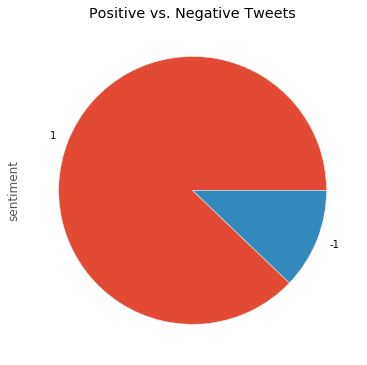

In [18]:
# Plot overall distribuation of positive vs. negative tweets
sent = data_evaluation_nn.sentiment.value_counts()
sent.plot(kind='pie', title = 'Positive vs. Negative Tweets', figsize=[6,6])

### ix) Export results

In [19]:
data_evaluation_nn = data_evaluation_nn[data_evaluation_nn.id.notnull()]

In [20]:
# formating id
#add two zeros after ####, delete #### before and after jpg, add dot before jpg
data_evaluation_nn.id = data_evaluation_nn.id.apply(lambda x: (x[0:11] + '00' + x[11:18] + '.jpg'))

In [21]:
true_labels = pd.read_csv("Data_LabelsSelma.csv", sep=";")

In [22]:
true_labels['id'] = true_labels['id'].str[0:11] + '00' + true_labels['id'].str[11:18] + '.jpg'
true_labels['true_sentiment'] = true_labels['Labels_Text'] 

In [23]:
true_labels.true_sentiment = true_labels.true_sentiment.astype('category')

In [24]:
data_evaluation_nn.sentiment = data_evaluation_nn.sentiment.astype('category').cat.codes
data_evaluation_nn.sentiment[data_evaluation_nn.sentiment == 0] = -1

C:\Users\Philipp\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
export = pd.merge(data_evaluation_nn, true_labels, on = 'id', how = 'left')

In [26]:
#accuracy
from sklearn.metrics import accuracy_score

In [27]:
accuracy_score(export.loc[~export['true_sentiment'].isnull(),'true_sentiment'], export.loc[~export['true_sentiment'].isnull(),'sentiment'])

0.65500000000000003

## Always choosing 1 is best:

In [28]:
accuracy_score(export.loc[~export['true_sentiment'].isnull(),'true_sentiment'], np.ones(export.loc[~export['true_sentiment'].isnull(),'true_sentiment'].shape[0]))

0.495

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [30]:
print(classification_report(export.loc[~export['true_sentiment'].isnull(),'true_sentiment'], export.loc[~export['true_sentiment'].isnull(),'sentiment'], labels = [-1, 1]))

             precision    recall  f1-score   support

         -1       0.88      0.37      0.52       101
          1       0.59      0.95      0.73        99

avg / total       0.74      0.66      0.62       200



In [ ]:
# Export results to CSV file
#export.to_csv("results_dict.csv", index=False)